# Long Short-Term Memory networks

## Introduction

In the field of plasma physics, understanding and predicting transitions in tokamak plasmas is crucial for advancing fusion energy research. One particular area of interest is predicting back-transitions, which can significantly affect plasma stability and the overall efficiency of a tokamak.

This notebook focuses on using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN), to predict back-transitions in tokamak plasmas. LSTMs are well-suited for this task due to their ability to capture long-term dependencies in sequential data, making them a powerful tool for time-series prediction problems in plasma physics.

The objectives of this notebook are as follows:

1. Feature Selection: Test different preprocessing methods, such as Fast Fourier Transform (FFT), and select features that enhance the model’s predictive capability.
2. Hyperparameter Optimization: Identify the best hyperparameters for the LSTM model, including the number of hidden units, layers, learning rate, and batch size, to obtain optimal performance.
3. Performance Evaluation: Compare the model’s performance across various configurations using  metrics such as accuracy, precision, recall, and F1 score.
4. Model Saving and Reusability: Save each trained model as a .pth file for future use and provide a dedicated cell for loading and utilizing the saved model.

In [ ]:
#!pip install "dask[dataframe]"
#!pip install optuna

import os
import glob
import json
import random
from collections import Counter
import numpy as np
import pandas as pd
import dask.dataframe as dd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.utils.rnn as rnn_utils
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna

### Data Splitting: Ensuring Shot-Level Separation

To ensure that time windows from a single plasma shot are not distributed across the training, validation or test sets, this notebook includes a function for data splitting. This function ensures that an entire shot is assigned exclusively to one of the subsets (train, validation or test). This approach prevents data leakage and ensures that the model generalizes well to unseen shots as it avoids overlap between subsets.

In [3]:
def split_shots(selected_shots, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    if seed is not None:
        random.seed(seed)  # For reproducibility
    random.shuffle(selected_shots)

    total_shots = len(selected_shots)
    train_size = int(total_shots * train_ratio)
    val_size   = int(total_shots * val_ratio)

    train_shots = selected_shots[:train_size]
    val_shots   = selected_shots[train_size:train_size + val_size]
    test_shots  = selected_shots[train_size + val_size:]
    return train_shots, val_shots, test_shots

### Window Function for Time-Based Prediction

For predicting back-transitions, this notebook uses a window-based approach. The model is designed to make predictions within a specific time window (for example, determining if a transition will occur within the next 100 milliseconds). This approach allows the model to focus on short-term temporal dependencies while leveraging the sequential structure of the data. 

By framing the prediction problem in terms of time windows, we can better capture the dynamic nature of tokamak plasma measurements and provide better insights for real-time plasma control and stability.

In [4]:
def create_windows_and_labels(selected_shots_number, pq_all, HL_times,
                              shot_number_train_set, shot_number_test_set,
                              shot_number_val_set, window_size=0.1,
                              global_mean=None, global_std=None):
    """
    Creates the windowed data (arrays) and labels for train/val/test sets.
    Returns: windows_train, labels_train, windows_test, labels_test, windows_val, labels_val
    """

    if global_mean is None or global_std is None:
        raise ValueError("Global mean and standard deviation must be provided.")

    windows_train, labels_train = [], []
    windows_test,  labels_test  = [], []
    windows_val,   labels_val   = [], []

    feature_columns = None

    for shot_number in selected_shots_number:
        # Load the parquet for a single shot
        shot_data = pd.read_parquet(pq_all[shot_number])
        shot_data.interpolate(method='linear', inplace=True)
        shot_data.dropna(inplace=True)

        if feature_columns is None:
            feature_columns = [col for col in shot_data.columns if col != 'time']

        time_values    = shot_data['time'].values
        feature_values = shot_data[feature_columns].values
        transition_times = np.array(HL_times.get(shot_number, []))

        start_time = time_values[0]
        end_time   = time_values[-1]

        # Determine the start and end indices for each window
        start_indices = np.searchsorted(time_values, np.arange(start_time, end_time, window_size))
        end_indices   = np.searchsorted(time_values, np.arange(start_time + window_size, end_time + window_size, window_size))

        for start_idx, end_idx in zip(start_indices, end_indices):
            if start_idx == end_idx:  # skip empty windows
                continue

            # Standardize using global stats
            window_array = (feature_values[start_idx:end_idx] - global_mean.values) / global_std.values

            # Label the window if it contains an HL transition time
            current_time_start = time_values[start_idx]
            current_time_end   = time_values[end_idx - 1]
            label = int(np.any((transition_times >= current_time_start) & (transition_times < current_time_end)))

            # Append to the appropriate dataset
            if shot_number in shot_number_train_set:
                windows_train.append(window_array)
                labels_train.append(label)
            elif shot_number in shot_number_test_set:
                windows_test.append(window_array)
                labels_test.append(label)
            elif shot_number in shot_number_val_set:
                windows_val.append(window_array)
                labels_val.append(label)

    # Debug prints
    print(f"Number of windows_train: {len(windows_train)}")
    if len(windows_train) > 0:
        print(f"Shape of one window (train example): {windows_train[0].shape}")
    print(f"Number of windows_test: {len(windows_test)}")
    print(f"Number of windows_val: {len(windows_val)}")

    return windows_train, labels_train, windows_test, labels_test, windows_val, labels_val

In [5]:
# -----------------------
#     PyTorch Dataset
# -----------------------
class HLTransitionWindowDataset(Dataset):
    def __init__(self, windowed_data, windowed_labels):
        self.windowed_data = windowed_data
        self.windowed_labels = windowed_labels

    def __len__(self):
        return len(self.windowed_data)

    def __getitem__(self, idx):
        X = torch.FloatTensor(self.windowed_data[idx])   # shape: (window_length, num_features)
        y = torch.FloatTensor([self.windowed_labels[idx]])
        return X, y

def collate_fn(batch):
    """
    Collate function that pads variable-length sequences in the same batch.
    Returns padded X, labels, and the original lengths.
    """
    X_batch, y_batch = zip(*batch)
    lengths = [x.size(0) for x in X_batch]  # original lengths for each sequence

    # Pad sequences to max length in the batch
    X_batch_padded = pad_sequence(X_batch, batch_first=True)  # shape: (batch_size, max_length, num_features)

    y_batch = torch.stack(y_batch).float()  # shape: (batch_size, 1)
    return X_batch_padded, y_batch, torch.tensor(lengths)

# -------------------------
#     Model Definition
# -------------------------
class HLTransitionPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(HLTransitionPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)

    def forward(self, x, lengths):
        """
        x shape: (batch_size, seq_length, input_size)
        lengths: the original sequence lengths before padding.
        """
        # Pack the padded input to optimize LSTM computation
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (h_n, _) = self.lstm(packed_input)
        # Use the final hidden state from the last layer of LSTM
        out = self.fc(h_n[-1])  # h_n[-1] is the hidden state for the last LSTM layer
        return out

In [6]:
# ----------------------------
#     Evaluation Function
# ----------------------------
def evaluate_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch, lengths in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = torch.sigmoid(model(X_batch, lengths))
            # Squeeze to match shapes if necessary
            if outputs.dim() == 2 and outputs.shape[1] == 1:
                outputs = outputs.squeeze(dim=1)
            if y_batch.dim() == 2 and y_batch.shape[1] == 1:
                y_batch = y_batch.squeeze(dim=1)

            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return accuracy, precision, recall, f1

In [7]:
# -----------------------------
#  Function to Get DataLoaders
# -----------------------------
def get_data(pq_all, HL_times, selected_shots_number,
             train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42, window_size=0.1):
    # Split shots
    train_shots, val_shots, test_shots = split_shots(
        selected_shots_number,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        test_ratio=test_ratio,
        seed=seed
    )

    # Compute global mean/std using Dask
    ddf = dd.concat([dd.read_parquet(pq_all[shot]) for shot in selected_shots_number])
    feature_columns = [col for col in ddf.columns if col != 'time']
    global_mean = ddf[feature_columns].mean().compute()
    global_std  = ddf[feature_columns].std().compute()

    # Create windows and labels
    windows_train, labels_train, windows_test, labels_test, windows_val, labels_val = create_windows_and_labels(
        selected_shots_number, pq_all, HL_times,
        shot_number_train_set=train_shots,
        shot_number_test_set=test_shots,
        shot_number_val_set=val_shots,
        window_size=window_size,
        global_mean=global_mean,
        global_std=global_std
    )

    # Create Datasets
    train_dataset = HLTransitionWindowDataset(windows_train, labels_train)
    val_dataset   = HLTransitionWindowDataset(windows_val,   labels_val)
    test_dataset  = HLTransitionWindowDataset(windows_test,  labels_test)

    return train_dataset, val_dataset, test_dataset, feature_columns


In [8]:
# -----------------------------
#    Training for One Epoch
# -----------------------------
# The purpose of training for a single epoch is to update the model’s parameters 
# once using the entire training dataset. 
# This allows us to measure how well the model is learning and adjust hyperparameters 
# or stop early if necessary.

def train_one_epoch(model, criterion, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch, lengths in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        lengths = lengths.to(device)

        outputs = model(X_batch, lengths)  # shape: (batch_size, 1)

        # Ensure y_batch has shape (batch_size, 1)
        if y_batch.dim() == 1:
            y_batch = y_batch.unsqueeze(1)

        loss = criterion(outputs, y_batch)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    # Compute training metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return total_loss / len(data_loader), f1

### Hyperparameter Tuning with Optuna

Using Optuna allows us to efficiently search for the best combination of hyperparameters. This approach leverages a trial-based optimization strategy to find hyperparameters that minimize the validation loss in order to improve the model's predictive performance.

In [12]:
# -----------------------------
#   Optuna Objective Function
# -----------------------------
def objective(trial, train_dataset, val_dataset, feature_columns, device):
    """
    The objective function to be optimized by Optuna.
    We define a small search space for hidden_size, num_layers, and learning_rate.
    You can expand or adjust as needed.
    """

    # Hyperparameter search space
    hidden_size   = trial.suggest_int("hidden_size", 32, 128, step=16)
    num_layers    = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size    = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    # Print which trial is being started + chosen params
    print(f"\n--- Trial {trial.number} / Params: hidden_size={hidden_size}, "
          f"num_layers={num_layers}, learning_rate={learning_rate:.5f}, batch_size={batch_size} ---")

    # Create data loaders with the trial-specific batch size
    train_data_loader = DataLoader(train_dataset,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   collate_fn=collate_fn)
    val_data_loader   = DataLoader(val_dataset,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   collate_fn=collate_fn)

    # Count classes in train dataset to build WeightedRandomSampler or pos_weight if desired
    labels_train = [lbl for lbl in train_dataset.windowed_labels]
    label_counts = Counter(labels_train)
    num_negative = label_counts.get(0, 0)
    num_positive = label_counts.get(1, 0)

    if num_positive == 0:
        pos_weight = torch.tensor([1.0], dtype=torch.float32).to(device)
    else:
        pos_weight = torch.tensor([num_negative / max(1, num_positive)], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Build model, optimizer
    input_size = len(feature_columns)
    model = HLTransitionPredictor(input_size, hidden_size, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 10
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        print(f"[Trial {trial.number}] Epoch {epoch+1}/{num_epochs} ...")
        train_loss, train_f1 = train_one_epoch(model, criterion, optimizer, train_data_loader, device)
        val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_data_loader, device)

        print(f"  Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        # Report intermediate results to Optuna
        trial.report(val_f1, epoch)

        # Check for pruning
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

    # Return the best validation F1 of this trial
    return best_val_f1


In [13]:
def run_optuna_optimization(pq_path, hl_json_path, selected_shots_number, n_trials=20, seed=42):
    """
    Master function that:
    1) Loads the data,
    2) Creates train/val/test sets,
    3) Runs Optuna study to find best hyperparams,
    4) Retrains and evaluates the final model on test set,
    5) Saves the final model weights.
    """
    pq_all_files = glob.glob(os.path.join(pq_path, '*_processed.parquet'))
    pq_all = {int(os.path.basename(f).split("_processed.parquet")[0]): f for f in pq_all_files}

    with open(hl_json_path, 'r') as f:
        HL_times = json.load(f)
        HL_times = {int(k): v for k, v in HL_times.items()}

    train_dataset, val_dataset, test_dataset, feature_columns = get_data(
        pq_all=pq_all,
        HL_times=HL_times,
        selected_shots_number=selected_shots_number,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15,
        seed=seed,
        window_size=0.1
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def optuna_objective(trial):
        return objective(trial, train_dataset, val_dataset, feature_columns, device)

    study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=2, interval_steps=3)
    )
    study.optimize(optuna_objective, n_trials=n_trials)

    print("\n--- Optuna Study Results ---")
    print("Best Trial F1 Score:", study.best_value)
    print("Best Hyperparameters:", study.best_params)

    best_params = study.best_params
    best_hidden_size   = best_params["hidden_size"]
    best_num_layers    = best_params["num_layers"]
    best_learning_rate = best_params["learning_rate"]
    best_batch_size    = best_params["batch_size"]

    input_size  = len(feature_columns)
    final_model = HLTransitionPredictor(input_size, best_hidden_size, best_num_layers).to(device)

    labels_train = [lbl for lbl in train_dataset.windowed_labels]
    label_counts = Counter(labels_train)
    num_negative = label_counts.get(0, 0)
    num_positive = label_counts.get(1, 0)
    if num_positive == 0:
        pos_weight = torch.tensor([1.0], dtype=torch.float32).to(device)
    else:
        pos_weight = torch.tensor([num_negative / max(1, num_positive)], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_learning_rate)

    train_data_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True, collate_fn=collate_fn)
    val_data_loader   = DataLoader(val_dataset,   batch_size=best_batch_size, shuffle=False, collate_fn=collate_fn)
    test_data_loader  = DataLoader(test_dataset,  batch_size=best_batch_size, shuffle=False, collate_fn=collate_fn)

    # Retrain final model
    num_epochs = 20
    for epoch in range(num_epochs):
        train_loss, train_f1 = train_one_epoch(final_model, criterion, optimizer, train_data_loader, device)

    # Evaluate on test set
    test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(final_model, test_data_loader, device)
    print("\n--- Final Test Results with Best Hyperparams ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    # 8) SAVE the final model checkpoint
    torch.save(final_model.state_dict(), "/content/drive/MyDrive/LSTM_0_final.pth")
    print("Final model weights saved to /content/drive/MyDrive/LSTM_0_final.pth")

    return study


### Wrapping Up for Optimization

In this section, we bring everything together to perform hyperparameter optimization using Optuna. The shot numbers are extracted from the filenames to define the specific data to be used during optimization. 

Finally, we call the `run_optuna_optimization` function, which does the process of searching for the best hyperparameters. This step enables us to fine-tune the model for optimal performance.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

pq_path = "/content/drive/MyDrive/preprocessed_features0"
hl_json_path = "/content/drive/MyDrive/HL_times.json"

pq_all_files = glob.glob(os.path.join(pq_path, '*_processed.parquet'))

selected_shots_number = [int(os.path.basename(f).split("_processed.parquet")[0]) for f in pq_all_files]


    # Run Optuna optimization
study = run_optuna_optimization(
      pq_path=pq_path,
      hl_json_path=hl_json_path,
      selected_shots_number=selected_shots_number,
      n_trials=10,   # number of trials for hyperparameter search
      seed=42
    )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2024-12-18 00:14:41,204] A new study created in memory with name: no-name-12946eaf-d5c3-4462-815b-9f8598a0cd3a


Number of windows_train: 2613
Shape of one window (train example): (1000, 143)
Number of windows_test: 545
Number of windows_val: 561

--- Trial 0 / Params: hidden_size=80, num_layers=3, learning_rate=0.00112, batch_size=32 ---
[Trial 0] Epoch 1/10 ...
  Train Loss: 0.9664 | Train F1: 0.3857 | Val F1: 0.4074
[Trial 0] Epoch 2/10 ...
  Train Loss: 0.8355 | Train F1: 0.4607 | Val F1: 0.4843
[Trial 0] Epoch 3/10 ...
  Train Loss: 0.7339 | Train F1: 0.4972 | Val F1: 0.4952
[Trial 0] Epoch 4/10 ...
  Train Loss: 0.8081 | Train F1: 0.4923 | Val F1: 0.4860
[Trial 0] Epoch 5/10 ...
  Train Loss: 0.7163 | Train F1: 0.5554 | Val F1: 0.4762
[Trial 0] Epoch 6/10 ...
  Train Loss: 0.6498 | Train F1: 0.5682 | Val F1: 0.4746
[Trial 0] Epoch 7/10 ...
  Train Loss: 0.6588 | Train F1: 0.5685 | Val F1: 0.5032
[Trial 0] Epoch 8/10 ...
  Train Loss: 0.6267 | Train F1: 0.5839 | Val F1: 0.4935
[Trial 0] Epoch 9/10 ...
  Train Loss: 0.6463 | Train F1: 0.5723 | Val F1: 0.4118
[Trial 0] Epoch 10/10 ...


[I 2024-12-18 00:16:15,455] Trial 0 finished with value: 0.5032258064516129 and parameters: {'hidden_size': 80, 'num_layers': 3, 'learning_rate': 0.0011223600526648913, 'batch_size': 32}. Best is trial 0 with value: 0.5032258064516129.


  Train Loss: 0.6244 | Train F1: 0.5877 | Val F1: 0.4425

--- Trial 1 / Params: hidden_size=80, num_layers=2, learning_rate=0.00405, batch_size=4 ---
[Trial 1] Epoch 1/10 ...
  Train Loss: 1.0115 | Train F1: 0.3945 | Val F1: 0.3723
[Trial 1] Epoch 2/10 ...
  Train Loss: 0.8934 | Train F1: 0.4169 | Val F1: 0.4706
[Trial 1] Epoch 3/10 ...
  Train Loss: 0.7792 | Train F1: 0.4861 | Val F1: 0.5000
[Trial 1] Epoch 4/10 ...
  Train Loss: 0.7226 | Train F1: 0.5217 | Val F1: 0.4830
[Trial 1] Epoch 5/10 ...
  Train Loss: 0.7033 | Train F1: 0.5144 | Val F1: 0.4664
[Trial 1] Epoch 6/10 ...
  Train Loss: 0.6800 | Train F1: 0.5346 | Val F1: 0.5481
[Trial 1] Epoch 7/10 ...
  Train Loss: 0.6304 | Train F1: 0.5680 | Val F1: 0.5545
[Trial 1] Epoch 8/10 ...
  Train Loss: 0.6234 | Train F1: 0.5415 | Val F1: 0.5040
[Trial 1] Epoch 9/10 ...
  Train Loss: 0.6752 | Train F1: 0.5414 | Val F1: 0.5200
[Trial 1] Epoch 10/10 ...


[I 2024-12-18 00:22:39,003] Trial 1 finished with value: 0.5545454545454546 and parameters: {'hidden_size': 80, 'num_layers': 2, 'learning_rate': 0.004045968458676973, 'batch_size': 4}. Best is trial 1 with value: 0.5545454545454546.


  Train Loss: 0.6536 | Train F1: 0.5276 | Val F1: 0.5198

--- Trial 2 / Params: hidden_size=128, num_layers=2, learning_rate=0.00046, batch_size=8 ---
[Trial 2] Epoch 1/10 ...
  Train Loss: 0.8898 | Train F1: 0.4158 | Val F1: 0.4356
[Trial 2] Epoch 2/10 ...
  Train Loss: 0.7836 | Train F1: 0.4905 | Val F1: 0.4679
[Trial 2] Epoch 3/10 ...
  Train Loss: 0.7517 | Train F1: 0.5114 | Val F1: 0.5100
[Trial 2] Epoch 4/10 ...
  Train Loss: 0.7070 | Train F1: 0.5365 | Val F1: 0.4286
[Trial 2] Epoch 5/10 ...
  Train Loss: 0.7158 | Train F1: 0.5032 | Val F1: 0.4480
[Trial 2] Epoch 6/10 ...
  Train Loss: 0.6704 | Train F1: 0.5426 | Val F1: 0.4932
[Trial 2] Epoch 7/10 ...
  Train Loss: 0.6290 | Train F1: 0.5732 | Val F1: 0.5143
[Trial 2] Epoch 8/10 ...
  Train Loss: 0.6107 | Train F1: 0.5746 | Val F1: 0.4933
[Trial 2] Epoch 9/10 ...
  Train Loss: 0.6077 | Train F1: 0.5979 | Val F1: 0.5213
[Trial 2] Epoch 10/10 ...


[I 2024-12-18 00:26:06,048] Trial 2 finished with value: 0.5326633165829145 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0004632611560391112, 'batch_size': 8}. Best is trial 1 with value: 0.5545454545454546.


  Train Loss: 0.6537 | Train F1: 0.5392 | Val F1: 0.5327

--- Trial 3 / Params: hidden_size=112, num_layers=3, learning_rate=0.00210, batch_size=16 ---
[Trial 3] Epoch 1/10 ...
  Train Loss: 1.0094 | Train F1: 0.4037 | Val F1: 0.4175
[Trial 3] Epoch 2/10 ...
  Train Loss: 0.9185 | Train F1: 0.4269 | Val F1: 0.4607
[Trial 3] Epoch 3/10 ...
  Train Loss: 0.8963 | Train F1: 0.4367 | Val F1: 0.4408
[Trial 3] Epoch 4/10 ...
  Train Loss: 0.8659 | Train F1: 0.4860 | Val F1: 0.4475
[Trial 3] Epoch 5/10 ...
  Train Loss: 0.8582 | Train F1: 0.4928 | Val F1: 0.4583
[Trial 3] Epoch 6/10 ...
  Train Loss: 0.8103 | Train F1: 0.5184 | Val F1: 0.4923
[Trial 3] Epoch 7/10 ...
  Train Loss: 0.7353 | Train F1: 0.5533 | Val F1: 0.4854
[Trial 3] Epoch 8/10 ...
  Train Loss: 0.7178 | Train F1: 0.5338 | Val F1: 0.4750
[Trial 3] Epoch 9/10 ...
  Train Loss: 0.7408 | Train F1: 0.4680 | Val F1: 0.4453
[Trial 3] Epoch 10/10 ...


[I 2024-12-18 00:28:49,606] Trial 3 finished with value: 0.49572649572649574 and parameters: {'hidden_size': 112, 'num_layers': 3, 'learning_rate': 0.002104517917842021, 'batch_size': 16}. Best is trial 1 with value: 0.5545454545454546.


  Train Loss: 0.6899 | Train F1: 0.5392 | Val F1: 0.4957

--- Trial 4 / Params: hidden_size=64, num_layers=1, learning_rate=0.00862, batch_size=8 ---
[Trial 4] Epoch 1/10 ...
  Train Loss: 0.9127 | Train F1: 0.4171 | Val F1: 0.3885
[Trial 4] Epoch 2/10 ...
  Train Loss: 0.8164 | Train F1: 0.4450 | Val F1: 0.4191
[Trial 4] Epoch 3/10 ...
  Train Loss: 0.7040 | Train F1: 0.5058 | Val F1: 0.4167
[Trial 4] Epoch 4/10 ...
  Train Loss: 0.6934 | Train F1: 0.4926 | Val F1: 0.4851
[Trial 4] Epoch 5/10 ...
  Train Loss: 0.6238 | Train F1: 0.5257 | Val F1: 0.5259
[Trial 4] Epoch 6/10 ...
  Train Loss: 0.5647 | Train F1: 0.5676 | Val F1: 0.5687
[Trial 4] Epoch 7/10 ...
  Train Loss: 0.6008 | Train F1: 0.5775 | Val F1: 0.5401
[Trial 4] Epoch 8/10 ...
  Train Loss: 0.6064 | Train F1: 0.5898 | Val F1: 0.4936
[Trial 4] Epoch 9/10 ...
  Train Loss: 0.6025 | Train F1: 0.5588 | Val F1: 0.5520
[Trial 4] Epoch 10/10 ...


[I 2024-12-18 00:30:32,916] Trial 4 finished with value: 0.6113989637305699 and parameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.008621736129726262, 'batch_size': 8}. Best is trial 4 with value: 0.6113989637305699.


  Train Loss: 0.5378 | Train F1: 0.5811 | Val F1: 0.6114

--- Trial 5 / Params: hidden_size=112, num_layers=3, learning_rate=0.00089, batch_size=32 ---
[Trial 5] Epoch 1/10 ...
  Train Loss: 0.9358 | Train F1: 0.3831 | Val F1: 0.4732
[Trial 5] Epoch 2/10 ...
  Train Loss: 0.7811 | Train F1: 0.4672 | Val F1: 0.4418
[Trial 5] Epoch 3/10 ...


[I 2024-12-18 00:31:03,630] Trial 5 pruned. 


  Train Loss: 0.7504 | Train F1: 0.5009 | Val F1: 0.4327

--- Trial 6 / Params: hidden_size=112, num_layers=2, learning_rate=0.00062, batch_size=4 ---
[Trial 6] Epoch 1/10 ...
  Train Loss: 0.9378 | Train F1: 0.4125 | Val F1: 0.3878
[Trial 6] Epoch 2/10 ...
  Train Loss: 0.8038 | Train F1: 0.4637 | Val F1: 0.4647
[Trial 6] Epoch 3/10 ...
  Train Loss: 0.8021 | Train F1: 0.4797 | Val F1: 0.5161
[Trial 6] Epoch 4/10 ...
  Train Loss: 0.7507 | Train F1: 0.5352 | Val F1: 0.4716
[Trial 6] Epoch 5/10 ...
  Train Loss: 0.7436 | Train F1: 0.5118 | Val F1: 0.4622
[Trial 6] Epoch 6/10 ...
  Train Loss: 0.7259 | Train F1: 0.5262 | Val F1: 0.4146
[Trial 6] Epoch 7/10 ...
  Train Loss: 0.7003 | Train F1: 0.5290 | Val F1: 0.4291
[Trial 6] Epoch 8/10 ...
  Train Loss: 0.6630 | Train F1: 0.5374 | Val F1: 0.4685
[Trial 6] Epoch 9/10 ...
  Train Loss: 0.6364 | Train F1: 0.5519 | Val F1: 0.5285
[Trial 6] Epoch 10/10 ...


[I 2024-12-18 00:37:38,901] Trial 6 finished with value: 0.5284974093264249 and parameters: {'hidden_size': 112, 'num_layers': 2, 'learning_rate': 0.0006171017963585639, 'batch_size': 4}. Best is trial 4 with value: 0.6113989637305699.


  Train Loss: 0.6270 | Train F1: 0.5738 | Val F1: 0.4328

--- Trial 7 / Params: hidden_size=64, num_layers=1, learning_rate=0.00144, batch_size=32 ---
[Trial 7] Epoch 1/10 ...
  Train Loss: 0.9155 | Train F1: 0.4006 | Val F1: 0.4426
[Trial 7] Epoch 2/10 ...
  Train Loss: 0.7952 | Train F1: 0.4575 | Val F1: 0.4427
[Trial 7] Epoch 3/10 ...


[I 2024-12-18 00:37:52,803] Trial 7 pruned. 


  Train Loss: 0.7326 | Train F1: 0.4940 | Val F1: 0.4661

--- Trial 8 / Params: hidden_size=96, num_layers=1, learning_rate=0.00013, batch_size=8 ---
[Trial 8] Epoch 1/10 ...
  Train Loss: 1.0066 | Train F1: 0.3577 | Val F1: 0.3918
[Trial 8] Epoch 2/10 ...
  Train Loss: 0.8675 | Train F1: 0.4241 | Val F1: 0.4417
[Trial 8] Epoch 3/10 ...


[I 2024-12-18 00:38:29,406] Trial 8 pruned. 


  Train Loss: 0.7736 | Train F1: 0.4829 | Val F1: 0.4630

--- Trial 9 / Params: hidden_size=64, num_layers=2, learning_rate=0.00210, batch_size=8 ---
[Trial 9] Epoch 1/10 ...
  Train Loss: 1.0408 | Train F1: 0.3519 | Val F1: 0.3647
[Trial 9] Epoch 2/10 ...
  Train Loss: 0.8653 | Train F1: 0.4112 | Val F1: 0.4272
[Trial 9] Epoch 3/10 ...
  Train Loss: 0.7838 | Train F1: 0.4609 | Val F1: 0.4979
[Trial 9] Epoch 4/10 ...
  Train Loss: 0.8285 | Train F1: 0.4613 | Val F1: 0.4603
[Trial 9] Epoch 5/10 ...
  Train Loss: 0.7860 | Train F1: 0.4839 | Val F1: 0.4496
[Trial 9] Epoch 6/10 ...
  Train Loss: 0.6970 | Train F1: 0.5153 | Val F1: 0.4565
[Trial 9] Epoch 7/10 ...
  Train Loss: 0.7202 | Train F1: 0.5099 | Val F1: 0.4739
[Trial 9] Epoch 8/10 ...
  Train Loss: 0.6884 | Train F1: 0.5129 | Val F1: 0.4372
[Trial 9] Epoch 9/10 ...
  Train Loss: 0.6747 | Train F1: 0.5385 | Val F1: 0.5374
[Trial 9] Epoch 10/10 ...


[I 2024-12-18 00:41:32,976] Trial 9 finished with value: 0.5463414634146342 and parameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.0020989443191869964, 'batch_size': 8}. Best is trial 4 with value: 0.6113989637305699.


  Train Loss: 0.6152 | Train F1: 0.5573 | Val F1: 0.5463

--- Optuna Study Results ---
Best Trial F1 Score: 0.6113989637305699
Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.008621736129726262, 'batch_size': 8}

--- Final Test Results with Best Hyperparams ---
Test Accuracy: 0.8532
Test Precision: 0.4454
Test Recall: 0.7910
Test F1 Score: 0.5699
Final model weights saved to /content/drive/MyDrive/LSTM_0_final.pth


In [ ]:
# Display the best F1 Score and hyperparameters associated
print("Best Trial F1 Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)


## Using the Final Model

This cell has all components to utilize the trained LSTM model for evaluation and predictions. It ensures access to preprocessed data and model weights, sets up reproducibility and prepares DataLoaders with optimal settings. The final model is evaluated on the test set and its performance metrics (accuracy, precision, recall, F1 score) are reported alongside a confusion matrix for detailed analysis.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of windows_train: 2613
Shape of one window (train example): (1000, 143)
Number of windows_test: 545
Number of windows_val: 561
Input size (number of features): 143
Model weights loaded from /content/drive/MyDrive/LSTM_0_final.pth

--- Final Model Performance on Test Set ---
Accuracy :  0.8532
Precision: 0.4454
Recall   : 0.7910
F1 Score : 0.5699
Confusion matrix plot saved to /content/drive/MyDrive/cmfinal_with_preprocess0noFFT.png


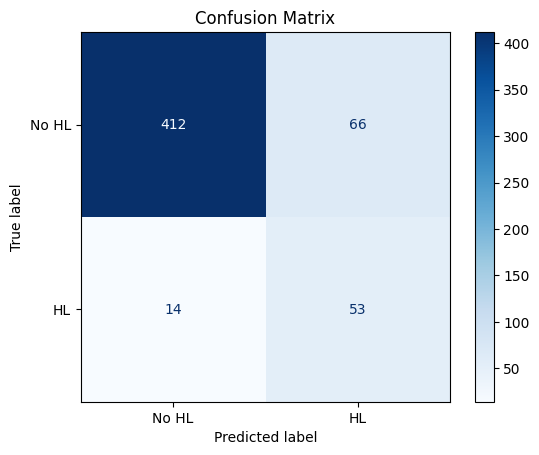

In [15]:
#!pip install "dask[dataframe]"
#!pip install optuna

from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import json
import random
from collections import Counter
import numpy as np
import pandas as pd
import dask.dataframe as dd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.utils.rnn as rnn_utils
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To ensure reproducibility 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Best hyperparameters for this preprocessed file (id=0 no FFT)
best_params = {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.008621736129726262, 'batch_size': 8}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Define the same model class used during training
class HLTransitionPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(HLTransitionPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (h_n, _) = self.lstm(packed_input)
        out = self.fc(h_n[-1])  # h_n[-1] = hidden state of the last LSTM layer
        return out

# 2) Prepare data and compute input size dynamically
pq_path = "/content/drive/MyDrive/preprocessed_features0"
hl_json_path = "/content/drive/MyDrive/HL_times.json"
pq_all_files = glob.glob(os.path.join(pq_path, '*_processed.parquet'))
pq_all = {int(os.path.basename(f).split("_processed.parquet")[0]): f for f in pq_all_files}

selected_shots_number = [int(os.path.basename(f).split("_processed.parquet")[0]) for f in pq_all_files]

with open(hl_json_path, 'r') as f:
        HL_times = json.load(f)
        HL_times = {int(k): v for k, v in HL_times.items()}

train_dataset, val_dataset, test_dataset, feature_columns = get_data(
    pq_all=pq_all,
    HL_times=HL_times,
    selected_shots_number=selected_shots_number,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=SEED,  # for reproducibility
    window_size=0.1
)
input_size = len(feature_columns)  # Determine input size
print(f"Input size (number of features): {input_size}")

# 3) Create and load the model
final_model = HLTransitionPredictor(
    input_size=input_size,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers']
).to(device)

model_path = "/content/drive/MyDrive/LSTM_0_final.pth"
final_model.load_state_dict(torch.load(model_path, map_location=device))
final_model.eval()
print(f"Model weights loaded from {model_path}")

# 4) Use DataLoaders with best batch_size
train_data_loader = DataLoader(
    train_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True,
    collate_fn=collate_fn
)
val_data_loader = DataLoader(
    val_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)
test_data_loader = DataLoader(
    test_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

# Evaluate the model
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch, lengths in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = torch.sigmoid(model(X_batch, lengths))
            preds   = (outputs > 0.5).float().cpu().numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy().flatten())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return accuracy, precision, recall, f1, np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Confusion matrix plot saved to {save_path}")
    plt.show()

# 5) Evaluate final model on test set
test_accuracy, test_precision, test_recall, test_f1, y_true, y_pred = evaluate_model(final_model, test_data_loader, device)

print("\n--- Final Model Performance on Test Set ---")
print(f"Accuracy :  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1 Score : {test_f1:.4f}")

# 6) Plot confusion matrix
class_names = ["No HL", "HL"]
plot_confusion_matrix(y_true, y_pred, class_names, save_path="/content/drive/MyDrive/cmfinal_with_preprocess0noFFT.png")


# Model Performance Summary

| Model Configuration                              | Accuracy | Precision | Recall  | F1 Score | Best Parameters                                                                 |
|--------------------------------------------------|----------|-----------|---------|----------|---------------------------------------------------------------------------------|
| LSTM with no preprocessing                       | 0.8068   | 0.3143    | 0.8250  | 0.4552   | {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.001}                   |
| LSTM with selected features 0, no FFT for Halpha | 0.8532   | 0.4454    | 0.7910  | 0.5699   | {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.0086, 'batch_size': 8} |
| LSTM with selected features 0, FFT for Halpha    | 0.8017   | 0.3563    | 0.9254  | 0.5145   | {'hidden_size': 96, 'num_layers': 1, 'learning_rate': 0.0083, 'batch_size': 16}|
| LSTM with selected features 1, no FFT for Halpha | 0.8399   | 0.4203    | 0.8529  | 0.5631   | {'hidden_size': 96, 'num_layers': 2, 'learning_rate': 0.0002, 'batch_size': 16}|
| LSTM with selected features 1, FFT for Halpha    | 0.7801   | 0.3520    | 0.7683  | 0.4828   | {'hidden_size': 80, 'num_layers': 3, 'learning_rate': 0.0019, 'batch_size': 8} |


## Conclusion
The results demonstrate that incorporating specific features and tuning hyperparameters significantly impacts the performance of the LSTM model in predicting back-transitions in tokamak plasma. Among the tested configurations, using selected features 0 without FFT preprocessing achieved the best accuracy (0.8532) and F1 score (0.5699) indicating that feature selection combined with optimized hyperparameters leads to improved model performance. 

In contrast, configurations using FFT preprocessing generally enhanced recall but resulted in lower precision and F1 scores.